In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 

import numpy as np
from psana import *
import psana, time

In [2]:
class Detector:
    
    """
    Detector object useful for reshaping data from XTC into detector shape. Stripped
    down version of Detector class from pysingfel when that library isn't available.
    """
    
    def __init__(self, geom_file):
        """
        Initialize instance of Detector class.
        
        :param geom_file: path to *-end.data geometry file
        """
        
        from PSCalib.GeometryAccess import GeometryAccess
        self._geometry = GeometryAccess(geom_file, 0)
        self._compute_pixel_index_map()
        
    def _compute_pixel_index_map(self):
        """
        Compute various parameters related to detector dimensions and pixel indices
        and store as class variables.
        """
        
        # Set coordinate in real space (convert to m)
        temp = [np.asarray(t) * 1e-6 for t in self._geometry.get_pixel_coords()]
        temp_index = [np.asarray(t) for t in self._geometry.get_pixel_coord_indexes()]
        self._panel_num = np.prod(temp[0].shape[:-2])
        self._shape = (self._panel_num, temp[0].shape[-2], temp[0].shape[-1])
        
        pixel_index_map = np.zeros(self._shape + (2,))
        for n in range(2):
            pixel_index_map[..., n] = temp_index[n].reshape(self._shape)
        self._pixel_index_map = pixel_index_map.astype(np.int64)

        self._detector_pixel_num_x = int(np.max(self._pixel_index_map[..., 0]) + 1)
        self._detector_pixel_num_y = int(np.max(self._pixel_index_map[..., 1]) + 1)
        
        self._panel_index = np.zeros((self._detector_pixel_num_x, self._detector_pixel_num_y))
        for l in range(self._panel_num):
            self._panel_index[self._pixel_index_map[l, :, :, 0],
                              self._pixel_index_map[l, :, :, 1]] = l+1
        
        return        
        
    def assemble_image_stack(self, data):
        """
        Reassemble data retrieved from XTC file into shape of detector.
        
        :param data: list of stacked data from each quad of panels
        :return image: data in shape of detector
        """
        data = np.array(data).reshape(self._shape)
        image = np.zeros((self._detector_pixel_num_x, self._detector_pixel_num_y)).astype(np.int64)
        
        for l in range(self._panel_num):
            image[self._pixel_index_map[l, :, :, 0],
                  self._pixel_index_map[l, :, :, 1]] = data[l, :, :]
            
        return image


In [3]:
def retrieve_cspad_data(evt):
    """
    Retrieve intensities collected on CsPad from input event.
    
    :param evt: psana event object
    :return data: list of quads that make up measured data
    """
    data = list()
    cspad = evt.get(psana.CsPad.DataV2, psana.Source('DscCsPad'))
    for num in range(cspad.quads_shape()[0]):
        data.append(cspad.quads(num).data())
    
    return data

In [4]:
pnum = 13
### py2
#pedestal_file = "/cds/data/psdm/cxi/cxic0415/calib/CsPad::CalibV1/CxiDs1.0:Cspad.0/pedestals/%i-end.data" %pnum
### py3
pedestal_file=f'/cds/data/psdm/cxi/cxic0415/calib/CsPad::CalibV1/CxiDs1.0:Cspad.0/pedestals/{pnum}-end.data'
geom_file = "/cds/data/psdm/cxi/cxic0415/calib/CsPad::CalibV1/CxiDs1.0:Cspad.0/geometry/0-end.data"
det = Detector(geom_file)

# Dictionary approach

In [47]:
start_time = time.time()

# retrieve several shots from dark and sample runs
dark, light = dict(), dict()
dark_idx, light_idx = 35, 36
total_evts = 10

for idx,d in zip([dark_idx, light_idx], [dark, light]):
    ds = psana.DataSource('exp=cxic0415:run=%i:smd' %idx)
    for num,evt in enumerate(ds.events()):
        if num == total_evts:
            break
        else:
            data = retrieve_cspad_data(evt)
            d[num] = det.assemble_image_stack(data)

# grab associated pedestal
pedestal = det.assemble_image_stack(np.loadtxt(pedestal_file))
            
print("elapsed time is %.2f min" %((time.time() - start_time)/60.0))

elapsed time is 0.05 min


Text(0, 0.5, 'Sample run')

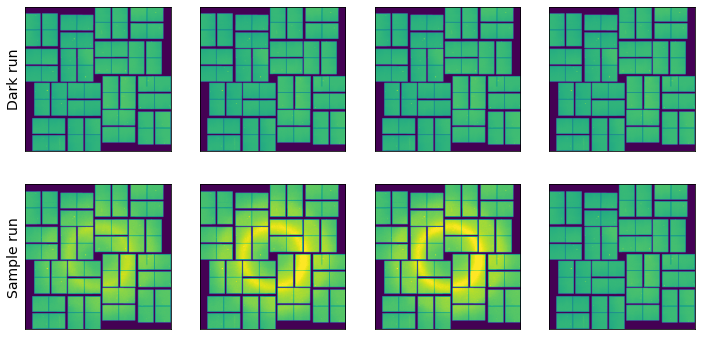

In [6]:
f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(12,6))

for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.imshow(dark[i+3], vmax=2*np.mean(dark[0]))
    ax.set_xticks([])
    ax.set_yticks([])

for i,ax in enumerate([ax5,ax6,ax7,ax8]):
    ax.imshow(light[i+3], vmax=2*np.mean(dark[0]))
    ax.set_xticks([])
    ax.set_yticks([])

ax1.set_ylabel("Dark run", fontsize=14)
ax5.set_ylabel("Sample run", fontsize=14)

In [126]:
#fig = plt.figure(figsize=(3,3),dpi=300)
#plt.title('Pedestal')
#plt.imshow(pedestal, vmax=2*np.mean(pedestal))

# PCA with numpy approach

In [152]:
start_time = time.time()

# run idx
run_idx = 36

# get dimensions
ds = psana.DataSource('exp=cxic0415:run=%i:smd' %run_idx)
for num_max,evt in enumerate(ds.events()):
    #print(num)
    if num_max == 0:
        data = retrieve_cspad_data(evt)
        image = det.assemble_image_stack(data) #.astype(np.int16)
print(f'{num} images of shape {image.shape} and type {image.dtype}')
print(np.unique(image))
            
if num_max > 100:
    num_max=100
    
# get all images
run_images = np.zeros((num_max, image.shape[0], image.shape[1]), dtype=image.dtype)
ds = psana.DataSource('exp=cxic0415:run=%i:smd' %run_idx)
for num,evt in enumerate(ds.events()):
    #print(num)
    if num == num_max:
        break
    else:
        data = retrieve_cspad_data(evt)
        run_images[num,...] = det.assemble_image_stack(data) #.astype(np.int16)
        run_images[num,...] -= pedestal
        #print(np.unique(run_images[num,...]))

print("elapsed time is %.2f min" %((time.time() - start_time)/60.0))

100 images of shape (1738, 1747) and type int64
[    0     1     3 ... 16191 16200 16234]
elapsed time is 0.32 min


In [153]:
from sklearn.decomposition import PCA

In [154]:
pca = PCA()
pca.fit(run_images.reshape(num_max, image.shape[0]*image.shape[1]))

PCA()

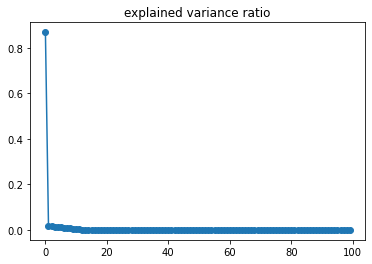

In [155]:
plt.title('explained variance ratio')
plt.plot(pca.explained_variance_ratio_, 'o-')
plt.show()

In [156]:
comps = pca.transform(run_images.reshape(num_max, image.shape[0]*image.shape[1]))

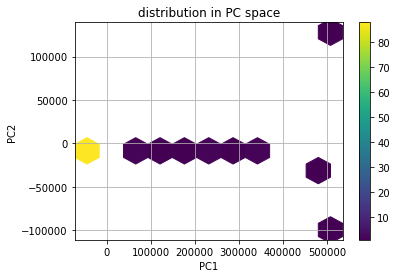

In [157]:
fig = plt.figure()
plt.title('distribution in PC space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.hexbin(comps[:,0], comps[:,1], mincnt=1,gridsize=10)
plt.grid()
plt.colorbar()
plt.show()

In [158]:
eigen_images = np.dot(comps.T,run_images.reshape(num_max, image.shape[0]*image.shape[1])).reshape(num_max, image.shape[0],image.shape[1])
print(eigen_images.shape)

(100, 1738, 1747)


Text(0.5, 1.0, 'PC2')

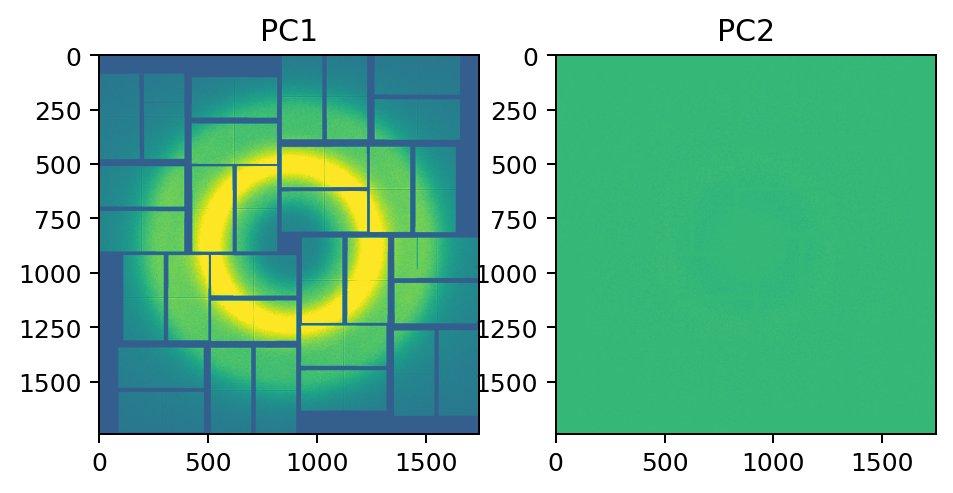

In [166]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,3),dpi=180)
im1 = ax1.imshow(eigen_images[0], vmax=3*np.std(eigen_images[0]))
ax1.set_title('PC1')
#fig.colorbar(im1, orientation='vertical')
im2 = ax2.imshow(eigen_images[1])
ax2.set_title('PC2')
#fig.colorbar(im2, orientation='vertical')

In [167]:
bulk_indices = np.where(comps[:,0]<0)[0]
outliers_indices = np.where(comps[:,0]>0)[0]
print(bulk_indices.shape, outliers_indices.shape)

(88,) (12,)


In [168]:
bulk_images = np.copy(run_images[bulk_indices,...])
outliers_images = np.copy(run_images[outliers_indices,...])

In [169]:
bulk_mean = np.mean(bulk_images,axis=0) 
outliers_mean = np.mean(outliers_images,axis=0) 
bulk_std = np.std(bulk_images,axis=0) 
outliers_std = np.std(outliers_images,axis=0) 

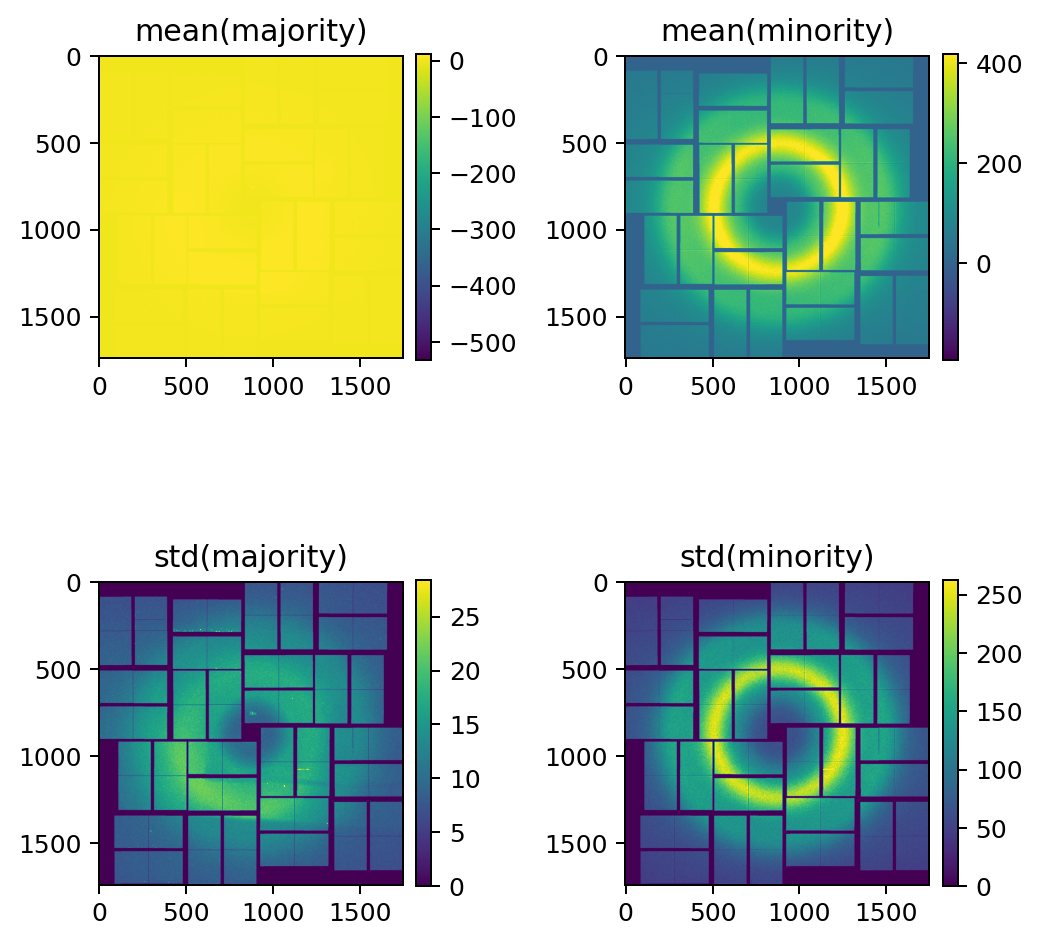

In [181]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(6,6),dpi=180)
im1 = ax1.imshow(bulk_mean, vmax=3*np.mean(bulk_mean))
ax1.set_title('mean(majority)')
cbar = f.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
im2 = ax2.imshow(outliers_mean, vmax=3*np.mean(outliers_mean))
ax2.set_title('mean(minority)')
cbar = f.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
im3 = ax3.imshow(bulk_std, vmax=3*np.mean(bulk_std))
ax3.set_title('std(majority)')
cbar = f.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
im4 = ax4.imshow(outliers_std, vmax=3*np.mean(outliers_std))
ax4.set_title('std(minority)')
cbar = f.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [186]:
np.unique(bulk_images[0])

array([-3157,  -830,  -468,  -441,  -342,  -263,  -195,  -175,  -165,
        -127,  -120,  -106,   -99,   -72,   -70,   -68,   -67,   -65,
         -59,   -57,   -56,   -52,   -50,   -40,   -36,   -34,   -33,
         -30,   -29,   -27,   -26,   -25,   -24,   -22,   -21,   -19,
         -18,   -17,   -16,   -15,   -14,   -13,   -12,   -11,   -10,
          -9,    -8,    -7,    -6,    -5,    -4,    -3,    -2,    -1,
           0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,